# Ак Барс 3А

Загрузка данных

In [1]:
%pip install openpyxl

In [2]:
import pandas as pd
import numpy as np

data = pd.read_excel('https://github.com/artemgur/akbars/raw/master/%D1%82%D0%B0%D0%B1%D0%BB%D0%B8%D1%86%D0%B0%203A.xlsx', engine='openpyxl')
data.head()

,NaturalPersonID,RequestDate,ProductName,CreditSum,TypeOfWork,Employment,SignIP,sex,age,EducationStatus,otrasl_rabotodatelya,kolichestvo_rabotnikov_v_organizacii,Employment.1,OrgStanding_N,kolichestvo_detej_mladshe_18,LivingRegionName,Residence,IncomeDocumentKind,HaveSalaryCard,IsBankWorker,TypeOfWork.1,SignIP.1,harakteristika_tekutschego_trudoustrojstva,ConfirmedMonthlyIncome (Target)
0,1ABD801A-0580-4C4F-9682-E7E85A749981,2018-10-16,Кредит на потребительские нужды,500000.0,NaN,Сотрудник \ Рабочий \ Ассистент,NaN,Женский,49,Высшее образование,Прочее,более 500,Сотрудник \ Рабочий \ Ассистент,1.25,0,Самара,город,Выписка по счету,нет,да,NaN,NaN,"Постоянная, полная занятость",30691.36
1,7B427911-9B96-443E-9EBA-76A02515E1BE,2018-10-19,Кредит на потребительские нужды,708000.0,NaN,Главный Специалист\Руководитель среднего звена,NaN,Женский,44,Среднее специальное образование,Государственная служба,до 20,Главный Специалист\Руководитель среднего звена,20.00,0,Казань,село,Выписка по счету,да,нет,NaN,NaN,"Постоянная, полная занятость",25712.07
2,4B867BD5-6398-4400-99CA-CF208714AF9A,2018-11-02,Кредит на потребительские нужды,665000.0,NaN,Сотрудник \ Рабочий \ Ассистент,NaN,Мужской,29,Высшее образование,Прочее,101-500,Сотрудник \ Рабочий \ Ассистент,2.00,1,Казань,город,Выписка по счету,да,нет,NaN,NaN,"Постоянная, полная занятость",31081.26
3,ED654BFA-A7E7-4280-84CA-D6EAE80E45E2,2018-11-02,Кредит на потребительские нужды,458000.0,NaN,Сотрудник \ Рабочий \ Ассистент,NaN,Женский,59,Несколько высших образований,Образование,21-100,Сотрудник \ Рабочий \ Ассистент,23.00,0,Зеленодольский,село,2-НДФЛ,да,нет,NaN,NaN,"Постоянная, полная занятость",17848.79
4,CCA3FF37-D508-449E-869A-6ED4CB6F9943,2018-10-15,Кредит на потребительские нужды,969000.0,NaN,Сотрудник \ Рабочий \ Ассистент,NaN,Мужской,51,Высшее образование,Здравоохранение,более 500,Сотрудник \ Рабочий \ Ассистент,9.25,2,Тюмень,город,2-НДФЛ,нет,нет,NaN,NaN,"Постоянная, полная занятость",115380.53


Данные содержат большое количество пропусков. Нужно провести очистку данных.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10719 entries, 0 to 10718
Data columns (total 24 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   NaturalPersonID                             10719 non-null  object        
 1   RequestDate                                 10719 non-null  datetime64[ns]
 2   ProductName                                 10719 non-null  object        
 3   CreditSum                                   10713 non-null  float64       
 4   TypeOfWork                                  6151 non-null   object        
 5   Employment                                  10716 non-null  object        
 6   SignIP                                      72 non-null     object        
 7   sex                                         10719 non-null  object        
 8   age                                         10719 non-null  int64         
 9   Educat

Найдем стандартное отклонение столбцов data.

Прежде всего, нас здесь интересует ConfirmedMonthlyIncome (Target). Его дисперсия ≈ 26 980.

Знание стандартного отклонения дает возможность оценивать модели.

In [4]:
data.std()

CreditSum                          332707.564917
age                                    10.908387
OrgStanding_N                           8.290993
kolichestvo_detej_mladshe_18            0.829251
ConfirmedMonthlyIncome (Target)     27077.289774
dtype: float64

Все значения в столбце NaturalPersonID уникальны:

In [5]:
data['NaturalPersonID'].is_unique

True

Столбец NaturalPersonID содержит уникальные идентификаторы пользователей. Он не содержит полезной информации, так что удалим его.

In [6]:
data.drop('NaturalPersonID', inplace=True, axis=1)
data.head()

,RequestDate,ProductName,CreditSum,TypeOfWork,Employment,SignIP,sex,age,EducationStatus,otrasl_rabotodatelya,kolichestvo_rabotnikov_v_organizacii,Employment.1,OrgStanding_N,kolichestvo_detej_mladshe_18,LivingRegionName,Residence,IncomeDocumentKind,HaveSalaryCard,IsBankWorker,TypeOfWork.1,SignIP.1,harakteristika_tekutschego_trudoustrojstva,ConfirmedMonthlyIncome (Target)
0,2018-10-16,Кредит на потребительские нужды,500000.0,NaN,Сотрудник \ Рабочий \ Ассистент,NaN,Женский,49,Высшее образование,Прочее,более 500,Сотрудник \ Рабочий \ Ассистент,1.25,0,Самара,город,Выписка по счету,нет,да,NaN,NaN,"Постоянная, полная занятость",30691.36
1,2018-10-19,Кредит на потребительские нужды,708000.0,NaN,Главный Специалист\Руководитель среднего звена,NaN,Женский,44,Среднее специальное образование,Государственная служба,до 20,Главный Специалист\Руководитель среднего звена,20.00,0,Казань,село,Выписка по счету,да,нет,NaN,NaN,"Постоянная, полная занятость",25712.07
2,2018-11-02,Кредит на потребительские нужды,665000.0,NaN,Сотрудник \ Рабочий \ Ассистент,NaN,Мужской,29,Высшее образование,Прочее,101-500,Сотрудник \ Рабочий \ Ассистент,2.00,1,Казань,город,Выписка по счету,да,нет,NaN,NaN,"Постоянная, полная занятость",31081.26
3,2018-11-02,Кредит на потребительские нужды,458000.0,NaN,Сотрудник \ Рабочий \ Ассистент,NaN,Женский,59,Несколько высших образований,Образование,21-100,Сотрудник \ Рабочий \ Ассистент,23.00,0,Зеленодольский,село,2-НДФЛ,да,нет,NaN,NaN,"Постоянная, полная занятость",17848.79
4,2018-10-15,Кредит на потребительские нужды,969000.0,NaN,Сотрудник \ Рабочий \ Ассистент,NaN,Мужской,51,Высшее образование,Здравоохранение,более 500,Сотрудник \ Рабочий \ Ассистент,9.25,2,Тюмень,город,2-НДФЛ,нет,нет,NaN,NaN,"Постоянная, полная занятость",115380.53


В данных есть полностью одинаковые столбцы. Удалим их

In [7]:
data['TypeOfWork'].equals(data['TypeOfWork.1']), data['Employment'].equals(data['Employment.1']), data['SignIP'].equals(data['SignIP.1'])

(True, True, True)

In [8]:
data.drop(['TypeOfWork.1', 'Employment.1', 'SignIP.1'], inplace=True, axis=1)
data.head(5)

,RequestDate,ProductName,CreditSum,TypeOfWork,Employment,SignIP,sex,age,EducationStatus,otrasl_rabotodatelya,kolichestvo_rabotnikov_v_organizacii,OrgStanding_N,kolichestvo_detej_mladshe_18,LivingRegionName,Residence,IncomeDocumentKind,HaveSalaryCard,IsBankWorker,harakteristika_tekutschego_trudoustrojstva,ConfirmedMonthlyIncome (Target)
0,2018-10-16,Кредит на потребительские нужды,500000.0,NaN,Сотрудник \ Рабочий \ Ассистент,NaN,Женский,49,Высшее образование,Прочее,более 500,1.25,0,Самара,город,Выписка по счету,нет,да,"Постоянная, полная занятость",30691.36
1,2018-10-19,Кредит на потребительские нужды,708000.0,NaN,Главный Специалист\Руководитель среднего звена,NaN,Женский,44,Среднее специальное образование,Государственная служба,до 20,20.00,0,Казань,село,Выписка по счету,да,нет,"Постоянная, полная занятость",25712.07
2,2018-11-02,Кредит на потребительские нужды,665000.0,NaN,Сотрудник \ Рабочий \ Ассистент,NaN,Мужской,29,Высшее образование,Прочее,101-500,2.00,1,Казань,город,Выписка по счету,да,нет,"Постоянная, полная занятость",31081.26
3,2018-11-02,Кредит на потребительские нужды,458000.0,NaN,Сотрудник \ Рабочий \ Ассистент,NaN,Женский,59,Несколько высших образований,Образование,21-100,23.00,0,Зеленодольский,село,2-НДФЛ,да,нет,"Постоянная, полная занятость",17848.79
4,2018-10-15,Кредит на потребительские нужды,969000.0,NaN,Сотрудник \ Рабочий \ Ассистент,NaN,Мужской,51,Высшее образование,Здравоохранение,более 500,9.25,2,Тюмень,город,2-НДФЛ,нет,нет,"Постоянная, полная занятость",115380.53


In [9]:
data['sex'].unique()

array(['Женский', 'Мужской'], dtype=object)

In [10]:
data['ProductName'].unique()

array(['Кредит на потребительские нужды', 'Кредитная карта'], dtype=object)

В данных есть бинарные признаки. Закодируем их через 0 и 1

In [11]:
data['sex'] = data['sex'].map({'Женский': 0, 'Мужской': 1})
data['ProductName'] = data['ProductName'].map({'Кредит на потребительские нужды': 0, 'Кредитная карта': 1})
data['HaveSalaryCard'] = data['HaveSalaryCard'].map({'нет': 0, 'да': 1})
data['IsBankWorker'] = data['IsBankWorker'].map({'нет': 0, 'да': 1})
data.head()

,RequestDate,ProductName,CreditSum,TypeOfWork,Employment,SignIP,sex,age,EducationStatus,otrasl_rabotodatelya,kolichestvo_rabotnikov_v_organizacii,OrgStanding_N,kolichestvo_detej_mladshe_18,LivingRegionName,Residence,IncomeDocumentKind,HaveSalaryCard,IsBankWorker,harakteristika_tekutschego_trudoustrojstva,ConfirmedMonthlyIncome (Target)
0,2018-10-16,0,500000.0,NaN,Сотрудник \ Рабочий \ Ассистент,NaN,0,49,Высшее образование,Прочее,более 500,1.25,0,Самара,город,Выписка по счету,0,1,"Постоянная, полная занятость",30691.36
1,2018-10-19,0,708000.0,NaN,Главный Специалист\Руководитель среднего звена,NaN,0,44,Среднее специальное образование,Государственная служба,до 20,20.00,0,Казань,село,Выписка по счету,1,0,"Постоянная, полная занятость",25712.07
2,2018-11-02,0,665000.0,NaN,Сотрудник \ Рабочий \ Ассистент,NaN,1,29,Высшее образование,Прочее,101-500,2.00,1,Казань,город,Выписка по счету,1,0,"Постоянная, полная занятость",31081.26
3,2018-11-02,0,458000.0,NaN,Сотрудник \ Рабочий \ Ассистент,NaN,0,59,Несколько высших образований,Образование,21-100,23.00,0,Зеленодольский,село,2-НДФЛ,1,0,"Постоянная, полная занятость",17848.79
4,2018-10-15,0,969000.0,NaN,Сотрудник \ Рабочий \ Ассистент,NaN,1,51,Высшее образование,Здравоохранение,более 500,9.25,2,Тюмень,город,2-НДФЛ,0,0,"Постоянная, полная занятость",115380.53


Единственная строка, где otrasl_rabotodatelya и kolichestvo_rabotnikov_v_organizacii — NaN. Эту строку следует убрать.

In [12]:
data[data['kolichestvo_rabotnikov_v_organizacii'].isnull()]

,RequestDate,ProductName,CreditSum,TypeOfWork,Employment,SignIP,sex,age,EducationStatus,otrasl_rabotodatelya,kolichestvo_rabotnikov_v_organizacii,OrgStanding_N,kolichestvo_detej_mladshe_18,LivingRegionName,Residence,IncomeDocumentKind,HaveSalaryCard,IsBankWorker,harakteristika_tekutschego_trudoustrojstva,ConfirmedMonthlyIncome (Target)
10568,2018-04-19,0,562500.0,Индивидуальный предприниматель,NaN,ИП,1,38,Высшее образование,NaN,NaN,1.25,2,Барнаул,город,Иное,0,0,"Постоянная, полная занятость",220834.0


In [13]:
data.drop(10568, inplace=True)
data[data['kolichestvo_rabotnikov_v_organizacii'].isnull()]

,RequestDate,ProductName,CreditSum,TypeOfWork,Employment,SignIP,sex,age,EducationStatus,otrasl_rabotodatelya,kolichestvo_rabotnikov_v_organizacii,OrgStanding_N,kolichestvo_detej_mladshe_18,LivingRegionName,Residence,IncomeDocumentKind,HaveSalaryCard,IsBankWorker,harakteristika_tekutschego_trudoustrojstva,ConfirmedMonthlyIncome (Target)


Признак kolichestvo_rabotnikov_v_organizacii закодируем числами от меньшего количества работников к большему

In [14]:
data['kolichestvo_rabotnikov_v_organizacii'].unique()

array(['более 500', 'до 20', '101-500', '21-100'], dtype=object)

In [15]:
data['kolichestvo_rabotnikov_v_organizacii'] = data['kolichestvo_rabotnikov_v_organizacii']\
    .map({'до 20': 0, '21-100': 1, '101-500': 2, 'более 500': 3})
data.head()

,RequestDate,ProductName,CreditSum,TypeOfWork,Employment,SignIP,sex,age,EducationStatus,otrasl_rabotodatelya,kolichestvo_rabotnikov_v_organizacii,OrgStanding_N,kolichestvo_detej_mladshe_18,LivingRegionName,Residence,IncomeDocumentKind,HaveSalaryCard,IsBankWorker,harakteristika_tekutschego_trudoustrojstva,ConfirmedMonthlyIncome (Target)
0,2018-10-16,0,500000.0,NaN,Сотрудник \ Рабочий \ Ассистент,NaN,0,49,Высшее образование,Прочее,3,1.25,0,Самара,город,Выписка по счету,0,1,"Постоянная, полная занятость",30691.36
1,2018-10-19,0,708000.0,NaN,Главный Специалист\Руководитель среднего звена,NaN,0,44,Среднее специальное образование,Государственная служба,0,20.00,0,Казань,село,Выписка по счету,1,0,"Постоянная, полная занятость",25712.07
2,2018-11-02,0,665000.0,NaN,Сотрудник \ Рабочий \ Ассистент,NaN,1,29,Высшее образование,Прочее,2,2.00,1,Казань,город,Выписка по счету,1,0,"Постоянная, полная занятость",31081.26
3,2018-11-02,0,458000.0,NaN,Сотрудник \ Рабочий \ Ассистент,NaN,0,59,Несколько высших образований,Образование,1,23.00,0,Зеленодольский,село,2-НДФЛ,1,0,"Постоянная, полная занятость",17848.79
4,2018-10-15,0,969000.0,NaN,Сотрудник \ Рабочий \ Ассистент,NaN,1,51,Высшее образование,Здравоохранение,3,9.25,2,Тюмень,город,2-НДФЛ,0,0,"Постоянная, полная занятость",115380.53


harakteristika_tekutschego_trudoustrojstva — "Частичная или временная занятость" практически у всех. Единственное другое значение — "Частичная или временная занятость", но строк с таким значением всего 15 из более 10000.
Это может привести к переобучению.

К тому же столбец содержит значительное количество NaN.

Удалим этот столбец.

In [16]:
data['harakteristika_tekutschego_trudoustrojstva'].unique(), data['harakteristika_tekutschego_trudoustrojstva'].value_counts()

(array(['Постоянная, полная занятость', nan,
        'Частичная или временная занятость'], dtype=object),
 Постоянная, полная занятость         10472
 Частичная или временная занятость       15
 Name: harakteristika_tekutschego_trudoustrojstva, dtype: int64)

In [17]:
data[data['harakteristika_tekutschego_trudoustrojstva'] == 'Частичная или временная занятость']

,RequestDate,ProductName,CreditSum,TypeOfWork,Employment,SignIP,sex,age,EducationStatus,otrasl_rabotodatelya,kolichestvo_rabotnikov_v_organizacii,OrgStanding_N,kolichestvo_detej_mladshe_18,LivingRegionName,Residence,IncomeDocumentKind,HaveSalaryCard,IsBankWorker,harakteristika_tekutschego_trudoustrojstva,ConfirmedMonthlyIncome (Target)
1009,2018-11-13,0,315481.19,NaN,Сотрудник \ Рабочий \ Ассистент,NaN,1,22,Среднее специальное образование,Государственная служба,3,0.583333,0,Йошкар-Ола,город,2-НДФЛ,0,0,Частичная или временная занятость,21217.56
2286,2018-11-12,1,50000.00,NaN,Главный Специалист\Руководитель среднего звена,NaN,1,41,Высшее образование,Прочее,1,5.000000,0,Казань,город,2-НДФЛ,0,0,Частичная или временная занятость,35178.86
4152,2017-06-28,0,162163.00,по найму,Сотрудник \ Рабочий \ Ассистент,NaN,0,37,Высшее образование,Образование,1,0.416666,0,Бугульминский,город,Выписка по счету,1,0,Частичная или временная занятость,16229.88
4885,2018-07-16,0,317660.86,NaN,Главный Специалист\Руководитель среднего звена,NaN,1,32,Высшее образование,"Правоохр.органы (МинОбороны, МинЮстиции)",3,10.000000,2,Псков,город,2-НДФЛ,0,0,Частичная или временная занятость,105257.97
5720,2017-03-23,0,40000.00,по найму,Главный Специалист\Руководитель среднего звена,NaN,0,42,Среднее специальное образование,Прочее,1,6.000000,1,Набережные Челны,село,Выписка по счету,1,0,Частичная или временная занятость,20814.32
6707,2018-09-04,0,500000.00,NaN,Сотрудник \ Рабочий \ Ассистент,NaN,1,35,Среднее специальное образование,Прочее,3,7.750000,2,Йошкар-Ола,село,Справка по форме Банка от работодателя,0,0,Частичная или временная занятость,42060.55
7463,2018-03-02,0,562500.00,по найму,Сотрудник \ Рабочий \ Ассистент,NaN,0,40,Высшее образование,Государственная служба,0,8.000000,1,Бугульминский,город,Выписка по счету,1,0,Частичная или временная занятость,23120.36
7708,2018-10-24,0,500000.00,NaN,Сотрудник \ Рабочий \ Ассистент,NaN,0,32,Высшее образование,Образование,1,4.666666,1,Мензелинский,село,Выписка по счету,1,0,Частичная или временная занятость,29736.21
8143,2017-06-01,0,162163.00,по найму,Сотрудник \ Рабочий \ Ассистент,NaN,0,45,Среднее специальное образование,"Правоохр.органы (МинОбороны, МинЮстиции)",3,4.083333,0,Зеленодольский,село,2-НДФЛ,0,0,Частичная или временная занятость,28538.99
8290,2018-09-26,0,2700000.00,NaN,Сотрудник \ Рабочий \ Ассистент,NaN,1,33,Высшее образование,Государственная служба,2,14.000000,2,Казань,село,2-НДФЛ,0,0,Частичная или временная занятость,51017.82


In [18]:
data.drop('harakteristika_tekutschego_trudoustrojstva', axis=1, inplace=True)

Далее подробно рассмотрим столбец SignIP.
Этот столбец содержит только 2 возможных значения: None и ИП.

In [20]:
data['SignIP'].unique(), data['SignIP'].value_counts()

(array([nan, 'ИП'], dtype=object), ИП    71
 Name: SignIP, dtype: int64)

Отделим строки, у которых значение — ИП, и проанализируем их.

In [21]:
dataIP = data[~data['SignIP'].isnull()]
dataIP.head()

,RequestDate,ProductName,CreditSum,TypeOfWork,Employment,SignIP,sex,age,EducationStatus,otrasl_rabotodatelya,kolichestvo_rabotnikov_v_organizacii,OrgStanding_N,kolichestvo_detej_mladshe_18,LivingRegionName,Residence,IncomeDocumentKind,HaveSalaryCard,IsBankWorker,ConfirmedMonthlyIncome (Target)
7,2018-11-12,0,710000.00,Собственное дело,Руководитель высшего звена,ИП,1,34,Высшее образование,"Архитектура, проектирование и конструирование",0,9.250000,2,Самара,город,Справка по форме Банка от работодателя,0,0,100050.00
130,2018-11-13,0,1362901.43,Собственное дело,Руководитель высшего звена,ИП,1,30,Высшее образование,Торговля и бытовые услуги населению,0,3.000000,1,Пермь,город,Справка по форме Банка от работодателя,0,0,195264.17
162,2018-11-01,0,1000000.00,Собственное дело,Главный Специалист\Руководитель среднего звена,ИП,1,32,Высшее образование,Торговля и бытовые услуги населению,0,5.500000,1,Казань,город,Справка по форме Банка от работодателя,0,0,213183.67
555,2018-07-27,0,944850.81,Собственное дело,Руководитель высшего звена,ИП,1,47,Высшее образование,Прочее,1,10.916666,0,Йошкар-Ола,город,Справка по форме Банка от работодателя,0,0,69600.00
755,2018-12-13,0,636000.00,Собственное дело,Руководитель высшего звена,ИП,1,30,Высшее образование,Прочее,0,1.083333,1,Ставрополь,город,Справка по форме Банка от работодателя,0,0,60357.00


Количества уникальных значений некоторых столбцов в этой выборке:

In [22]:
dataIP['TypeOfWork'].value_counts(), dataIP['Employment'].value_counts(), dataIP['IncomeDocumentKind'].value_counts(), dataIP['kolichestvo_rabotnikov_v_organizacii'].value_counts()

(Собственное дело                  54
 Индивидуальный предприниматель    17
 Name: TypeOfWork, dtype: int64,
 Руководитель высшего звена                        54
 Главный Специалист\Руководитель среднего звена     8
 Сотрудник \ Рабочий \ Ассистент                    4
 нет данных                                         2
 Индивидуальный предприниматель                     2
 Name: Employment, dtype: int64,
 Справка по форме Банка от работодателя    35
 2-НДФЛ                                    18
 Иное                                      15
 Выписка по счету                           3
 Name: IncomeDocumentKind, dtype: int64,
 0    48
 1    22
 2     1
 Name: kolichestvo_rabotnikov_v_organizacii, dtype: int64)

Количества уникальных значений тех же столбцов в изначальной выборке:

In [23]:
data['TypeOfWork'].value_counts(), data['Employment'].value_counts(), data['IncomeDocumentKind'].value_counts(), data['kolichestvo_rabotnikov_v_organizacii'].value_counts()

(по найму                          6074
 Собственное дело                    54
 Индивидуальный предприниматель      17
 Агент на комиссионом договоре        5
 Name: TypeOfWork, dtype: int64,
 Сотрудник \ Рабочий \ Ассистент                   7557
 Главный Специалист\Руководитель среднего звена    1624
 Эксперт\Старший или Ведущий Специалист             847
 Руководитель высшего звена                         679
 нет данных                                           6
 Индивидуальный предприниматель                       3
 Name: Employment, dtype: int64,
 2-НДФЛ                                    5370
 Выписка по счету                          4402
 Справка по форме Банка от работодателя     772
 Иное                                        43
 Нет (не предоставлен)                        1
 Name: IncomeDocumentKind, dtype: int64,
 3    4958
 1    2649
 2    2129
 0     982
 Name: kolichestvo_rabotnikov_v_organizacii, dtype: int64)

Можно заметить, что в ИП в столбце SignIP стоит у тех и только у тех людей, у которых TypeOfWork — "Собственное дело" или "Индивидуальный предприниматель"

Это означает, что NaN в столбце SignIP — не пропуск в данных. На самом деле SignIP — бинарный признак, а NaN и ИП — его значения. 

Закодируем признак через 0 и 1.

In [24]:
data['SignIP'] = data['SignIP'].replace({None: 0, 'ИП': 1})
data['SignIP'].value_counts()

0    10647
1       71
Name: SignIP, dtype: int64

Рассмотрим промежуточные результаты

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10718 entries, 0 to 10718
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   RequestDate                           10718 non-null  datetime64[ns]
 1   ProductName                           10718 non-null  int64         
 2   CreditSum                             10712 non-null  float64       
 3   TypeOfWork                            6150 non-null   object        
 4   Employment                            10716 non-null  object        
 5   SignIP                                10718 non-null  int64         
 6   sex                                   10718 non-null  int64         
 7   age                                   10718 non-null  int64         
 8   EducationStatus                       10718 non-null  object        
 9   otrasl_rabotodatelya                  10718 non-null  object        
 10

Столбец Employment содержит 6 значений "нет данных" и 2 NaN.

Также столбец содержит всего 3 значения "Индивидуальный предприниматель", что абсолютно нерепрезентативно.

Удалим все эти значения.

In [28]:
data['Employment'].unique(), data['Employment'].value_counts()

(array(['Сотрудник \\ Рабочий \\ Ассистент',
        'Главный Специалист\\Руководитель среднего звена',
        'Руководитель высшего звена',
        'Эксперт\\Старший или Ведущий Специалист',
        'Индивидуальный предприниматель', 'нет данных', nan], dtype=object),
 Сотрудник \ Рабочий \ Ассистент                   7557
 Главный Специалист\Руководитель среднего звена    1624
 Эксперт\Старший или Ведущий Специалист             847
 Руководитель высшего звена                         679
 нет данных                                           6
 Индивидуальный предприниматель                       3
 Name: Employment, dtype: int64)

In [29]:
data.drop(data[(data['Employment'].isnull()) | (data['Employment'] == 'нет данных') | (data['Employment'] == 'Индивидуальный предприниматель')].index, inplace=True, axis=0)
data['Employment'].unique(), data['Employment'].value_counts()

(array(['Сотрудник \\ Рабочий \\ Ассистент',
        'Главный Специалист\\Руководитель среднего звена',
        'Руководитель высшего звена',
        'Эксперт\\Старший или Ведущий Специалист'], dtype=object),
 Сотрудник \ Рабочий \ Ассистент                   7557
 Главный Специалист\Руководитель среднего звена    1624
 Эксперт\Старший или Ведущий Специалист             847
 Руководитель высшего звена                         679
 Name: Employment, dtype: int64)

Оставшиеся в столбце значения мы можем отранжировать в порядке возрастания уровня должности.

In [30]:
data['Employment'] = data['Employment'].map({"Сотрудник \ Рабочий \ Ассистент": 0, "Главный Специалист\Руководитель среднего звена": 1, "Эксперт\Старший или Ведущий Специалист": 3, "Руководитель высшего звена": 4})
data['Employment'].unique(), data['Employment'].value_counts()

(array([0, 1, 4, 3]), 0    7557
 1    1624
 3     847
 4     679
 Name: Employment, dtype: int64)

Есть 6 столбцов, сумма кредита в которых — NaN. Удалим их.

In [31]:
data.drop(data[data['CreditSum'].isnull()].index, inplace=True, axis=0)

Рассмотрим промежуточные результаты

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10701 entries, 0 to 10718
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   RequestDate                           10701 non-null  datetime64[ns]
 1   ProductName                           10701 non-null  int64         
 2   CreditSum                             10701 non-null  float64       
 3   TypeOfWork                            6136 non-null   object        
 4   Employment                            10701 non-null  int64         
 5   SignIP                                10701 non-null  int64         
 6   sex                                   10701 non-null  int64         
 7   age                                   10701 non-null  int64         
 8   EducationStatus                       10701 non-null  object        
 9   otrasl_rabotodatelya                  10701 non-null  object        
 10

В столбце IncomeDocumentKind 130 значений NaN. При этом в данных еще есть 1 значение "Нет (не предоставлен)".

Заменим NaN в столбце на "Нет (не предоставлен)"

In [33]:
data['IncomeDocumentKind'].value_counts()

2-НДФЛ                                    5365
Выписка по счету                          4398
Справка по форме Банка от работодателя     768
Иное                                        39
Нет (не предоставлен)                        1
Name: IncomeDocumentKind, dtype: int64

In [34]:
data['IncomeDocumentKind'] = data['IncomeDocumentKind'].replace({None: 'Нет (не предоставлен)'})
data['IncomeDocumentKind'].value_counts()

2-НДФЛ                                    5365
Выписка по счету                          4398
Справка по форме Банка от работодателя     768
Нет (не предоставлен)                      131
Иное                                        39
Name: IncomeDocumentKind, dtype: int64

In [35]:
data[data['OrgStanding_N'] == 0]

,RequestDate,ProductName,CreditSum,TypeOfWork,Employment,SignIP,sex,age,EducationStatus,otrasl_rabotodatelya,kolichestvo_rabotnikov_v_organizacii,OrgStanding_N,kolichestvo_detej_mladshe_18,LivingRegionName,Residence,IncomeDocumentKind,HaveSalaryCard,IsBankWorker,ConfirmedMonthlyIncome (Target)


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10701 entries, 0 to 10718
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   RequestDate                           10701 non-null  datetime64[ns]
 1   ProductName                           10701 non-null  int64         
 2   CreditSum                             10701 non-null  float64       
 3   TypeOfWork                            6136 non-null   object        
 4   Employment                            10701 non-null  int64         
 5   SignIP                                10701 non-null  int64         
 6   sex                                   10701 non-null  int64         
 7   age                                   10701 non-null  int64         
 8   EducationStatus                       10701 non-null  object        
 9   otrasl_rabotodatelya                  10701 non-null  object        
 10

NaN остались только в столбцах TypeOfWork и Residence. В этих столбцах NaN составляют очень большую долю.

Рассмотрим столбец RequestDate.

Выделим в отдельные столбцы год и месяц. Столбец RequestDate отконвертируем в timestamp.

In [38]:
data['year'] = data['RequestDate'].dt.year
data['year'].value_counts()

2018    6886
2017    3815
Name: year, dtype: int64

In [39]:
data['month'] = data['RequestDate'].dt.month
data['month'].value_counts()

11    1559
12    1336
10    1263
8      873
9      830
7      814
6      807
4      795
5      785
3      781
1      467
2      391
Name: month, dtype: int64

In [40]:
data['RequestDate'] = data['RequestDate'].astype('int64')
data['RequestDate'].value_counts()

1538611200000000000    249
1542758400000000000     93
1542672000000000000     76
1542844800000000000     70
1542153600000000000     67
                      ... 
1498262400000000000      1
1518825600000000000      1
1502496000000000000      1
1495929600000000000      1
1534636800000000000      1
Name: RequestDate, Length: 590, dtype: int64

Создадим признак "возрастная группа"

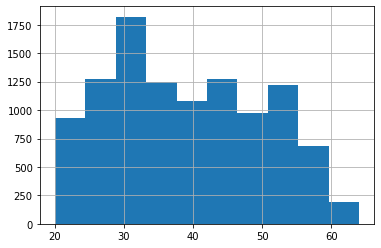

In [42]:
data['age'].hist()

In [43]:
def age_group(age):
    if age < 20:
        return 0
    elif 20 <= age < 30:
        return 1
    elif 30 <= age < 40:
        return 2
    elif 40 <= age < 50:
        return 3
    elif 50 <= age < 60:
        return 4
    elif 50 <= age < 60:
        return 5
    else:
        return 6

In [44]:
data['age_group'] = data.apply(lambda x: age_group(x['age']), axis=1)
data['age_group'].value_counts()

2    3259
1    2575
3    2526
4    2146
6     195
Name: age_group, dtype: int64

In [45]:
corr = data.corr()
corr

,RequestDate,ProductName,CreditSum,Employment,SignIP,sex,age,kolichestvo_rabotnikov_v_organizacii,OrgStanding_N,kolichestvo_detej_mladshe_18,HaveSalaryCard,IsBankWorker,ConfirmedMonthlyIncome (Target),year,month,age_group
RequestDate,1.000000,0.379810,0.077353,0.003769,-0.025454,-0.050928,-0.002817,0.041379,-0.025165,0.060039,-0.029735,0.191346,0.062206,0.884159,0.598054,-0.002971
ProductName,0.379810,1.000000,-0.362734,0.015665,-0.028896,-0.112667,-0.093501,0.063859,-0.103699,0.038964,-0.126481,0.439666,-0.016668,0.257328,0.367142,-0.087978
CreditSum,0.077353,-0.362734,1.000000,0.149861,0.048537,0.122017,0.099703,-0.012260,0.087978,0.071448,0.039095,-0.160394,0.349883,0.098262,-0.008822,0.084940
Employment,0.003769,0.015665,0.149861,1.000000,0.179082,-0.002081,0.069978,-0.124830,0.015940,0.067500,0.023162,0.086274,0.347357,0.005860,-0.001560,0.060432
SignIP,-0.025454,-0.028896,0.048537,0.179082,1.000000,0.034848,0.026343,-0.126942,-0.012575,0.031827,-0.039828,-0.025279,0.184703,-0.033569,0.002967,0.025702
sex,-0.050928,-0.112667,0.122017,-0.002081,0.034848,1.000000,-0.153079,0.120590,-0.197298,0.131046,-0.104229,-0.210859,0.184598,-0.036589,-0.046526,-0.142682
age,-0.002817,-0.093501,0.099703,0.069978,0.026343,-0.153079,1.000000,-0.159463,0.487741,-0.163136,0.143437,-0.132384,-0.017858,-0.006846,0.005020,0.958512
kolichestvo_rabotnikov_v_organizacii,0.041379,0.063859,-0.012260,-0.124830,-0.126942,0.120590,-0.159463,1.000000,-0.007092,0.014039,-0.147184,0.244563,0.071881,0.027222,0.043204,-0.152970
OrgStanding_N,-0.025165,-0.103699,0.087978,0.015940,-0.012575,-0.197298,0.487741,-0.007092,1.000000,-0.060085,0.163154,-0.086884,-0.003539,-0.023498,-0.012883,0.474546
kolichestvo_detej_mladshe_18,0.060039,0.038964,0.071448,0.067500,0.031827,0.131046,-0.163136,0.014039,-0.060085,1.000000,-0.019187,0.002732,0.205599,0.051453,0.039643,-0.159771


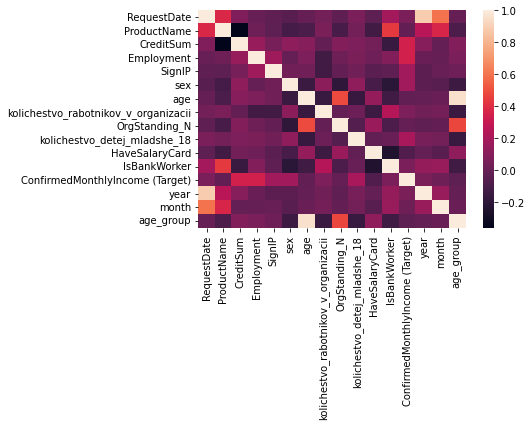

In [46]:
import seaborn as sns

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

Заполним пропуски в столбце Residence.

Если в регионе преобладают городские жители, будем задавать пропускам значение "город", а сельским — "село"

In [47]:
data['LivingRegionName'].value_counts()

Казань              2212
Набережные Челны     824
Нижнекамский         740
Чистопольский        653
Альметьевский        418
Уфа                  417
Нижегородский        375
Йошкар-Ола           340
Ижевск               338
Бавлинский           284
Зеленодольский       279
Санкт-Петербург      218
Елабужский           217
Бугульминский        193
Лениногорский        189
Саратов              186
Апастовский          186
Арский               185
Азнакаевский         184
Чебоксары            167
Буинский             162
Мензелинский         151
Челябинск            147
Заинский             147
Красноярск           144
Самара               134
Нурлатский           128
Оренбург              97
Мамадышский           94
Пермь                 91
Менделеевский         89
Тюмень                83
Москва                79
Екатеринбург          76
Кукморский            71
Ульяновск             66
Новгород Великий      63
Омск                  50
Барнаул               49
Краснодар             46


In [49]:
most_common_city_village = data.groupby(['LivingRegionName'])['Residence'].agg(pd.Series.mode).to_frame()
most_common_city_village

,Residence
LivingRegionName,
Азнакаевский,город
Альметьевский,город
Апастовский,село
Арский,село
Бавлинский,село
Барнаул,город
Бугульминский,город
Буинский,село
Вятские поляны,город


In [50]:
def na_to_most_common_city_village(row):
    if pd.isna(row['Residence']):
        return most_common_city_village.loc[row['LivingRegionName'], 'Residence']
    else:
        return row['Residence']

In [51]:
data['Residence'] = data.apply(na_to_most_common_city_village, axis=1)
data['Residence'].value_counts()

город    7597
село     3104
Name: Residence, dtype: int64

In [52]:
data['Residence'] = data['Residence'].replace({'село': 0, 'город': 1})
data['Residence'].value_counts()

1    7597
0    3104
Name: Residence, dtype: int64

Заметим, что строк, в которых target > 80000, крайне мало. Вряд ли модель сможет хорошо предсказывать эти значения, и в то же время они искажают результат для более распространенных значений.

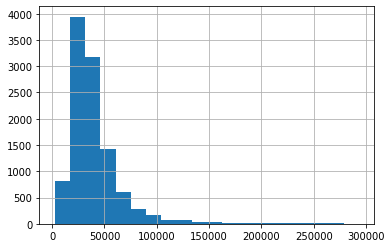

In [53]:
data['ConfirmedMonthlyIncome (Target)'].hist(bins=20)

In [54]:
data = data[data['ConfirmedMonthlyIncome (Target)'] < 80000]

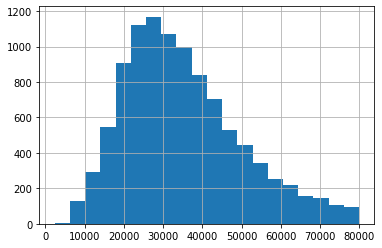

In [55]:
data['ConfirmedMonthlyIncome (Target)'].hist(bins=20)

Также в данных есть строки с очень низким доходом. Рассмотрим их подробнее

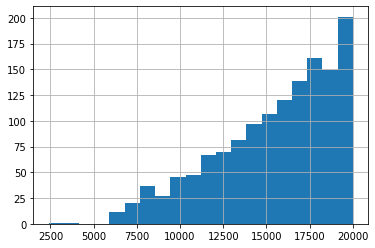

In [57]:
data[data['ConfirmedMonthlyIncome (Target)'] < 20000]['ConfirmedMonthlyIncome (Target)'].hist(bins=20)

Видно, что в данных есть очень малое количество значений с очень низким доходом.

В 2017-2018 годах прожиточный минимум для трудоспособного населения находился на уровне порядка 11000 рублей. Отбросим строки с доходом ниже этой цифры.

In [58]:
data = data[data['ConfirmedMonthlyIncome (Target)'] > 11000]

In [61]:
encoded = pd.get_dummies(data)
encoded

,RequestDate,ProductName,CreditSum,Employment,SignIP,sex,age,kolichestvo_rabotnikov_v_organizacii,OrgStanding_N,kolichestvo_detej_mladshe_18,Residence,HaveSalaryCard,IsBankWorker,ConfirmedMonthlyIncome (Target),year,month,age_group,TypeOfWork_Агент на комиссионом договоре,TypeOfWork_Индивидуальный предприниматель,TypeOfWork_Собственное дело,TypeOfWork_по найму,"EducationStatus_Академическая степень (кандидат наук, доктор наук и т.д.)",EducationStatus_Высшее образование,EducationStatus_Незаконченное высшее образование,EducationStatus_Незаконченное среднее образование,EducationStatus_Несколько высших образований,EducationStatus_Среднее образование,EducationStatus_Среднее специальное образование,"otrasl_rabotodatelya_Архитектура, проектирование и конструирование",otrasl_rabotodatelya_Государственная служба,otrasl_rabotodatelya_Здравоохранение,otrasl_rabotodatelya_Индустрия развлечений,otrasl_rabotodatelya_Информационные технологии,otrasl_rabotodatelya_Культура и искусство,otrasl_rabotodatelya_Логистика и поставки,otrasl_rabotodatelya_Маркетинг,otrasl_rabotodatelya_Машиностроение,otrasl_rabotodatelya_Металлургия,otrasl_rabotodatelya_Наука,otrasl_rabotodatelya_Недвижимость,...,LivingRegionName_Заинский,LivingRegionName_Зеленодольский,LivingRegionName_Ижевск,LivingRegionName_Йошкар-Ола,LivingRegionName_Казань,LivingRegionName_Киров,LivingRegionName_Краснодар,LivingRegionName_Красноярск,LivingRegionName_Кукморский,LivingRegionName_Лениногорский,LivingRegionName_Мамадышский,LivingRegionName_Менделеевский,LivingRegionName_Мензелинский,LivingRegionName_Москва,LivingRegionName_Набережные Челны,LivingRegionName_Нижегородский,LivingRegionName_Нижнекамский,LivingRegionName_Новгород Великий,LivingRegionName_Новосибирск,LivingRegionName_Нурлатский,LivingRegionName_Омск,LivingRegionName_Оренбург,LivingRegionName_Пермь,LivingRegionName_Псков,LivingRegionName_Самара,LivingRegionName_Санкт-Петербург,LivingRegionName_Саратов,LivingRegionName_Ставрополь,LivingRegionName_Тюмень,LivingRegionName_Ульяновск,LivingRegionName_Уфа,LivingRegionName_Чебоксары,LivingRegionName_Челябинск,LivingRegionName_Чистопольский,LivingRegionName_Ярославль,IncomeDocumentKind_2-НДФЛ,IncomeDocumentKind_Выписка по счету,IncomeDocumentKind_Иное,IncomeDocumentKind_Нет (не предоставлен),IncomeDocumentKind_Справка по форме Банка от работодателя
0,1539648000000000000,0,500000.00,0,0,0,49,3,1.250000,0,1,0,1,30691.36,2018,10,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1539907200000000000,0,708000.00,1,0,0,44,0,20.000000,0,0,1,0,25712.07,2018,10,3,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1541116800000000000,0,665000.00,0,0,1,29,2,2.000000,1,1,1,0,31081.26,2018,11,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1541116800000000000,0,458000.00,0,0,0,59,1,23.000000,0,0,1,0,17848.79,2018,11,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,1542067200000000000,1,35000.00,0,0,1,35,3,5.500000,0,1,1,0,39578.97,2018,11,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10713,1532563200000000000,0,538844.32,0,0,1,50,3,30.416666,0,1,0,0,59878.62,2018,7,4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
10715,1533772800000000000,0,105000.00,0,0,0,44,1,9.000000,0,1,1,0,

In [62]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(encoded.drop('ConfirmedMonthlyIncome (Target)', axis=1), encoded['ConfirmedMonthlyIncome (Target)'], test_size=0.2)

In [63]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [64]:
from sklearn.metrics import mean_squared_error

print(np.sqrt(mean_squared_error(y_train, lr.predict(x_train))))
print(np.sqrt(mean_squared_error(y_test, lr.predict(x_test))))

13859.997730068315
13683.836765123418


In [67]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features='sqrt', max_depth=5)
rf.fit(x_train, y_train)

RandomForestRegressor(max_depth=5, max_features='sqrt')

In [68]:
print(np.sqrt(mean_squared_error(y_train, rf.predict(x_train))))
print(np.sqrt(mean_squared_error(y_test, rf.predict(x_test))))

12575.739536172257
12429.607193628131


Сравним распределения тестовых значений и предсказаний случайного леса.

In [ ]:
y_test.hist(log=True)

In [ ]:
pd.Series(rf.predict(x_test)).hist(log=True)

Для создания модели будем использовать Pycaret

In [76]:
%%capture
pip install --use-deprecated=legacy-resolver pycaret[full]

In [77]:
import pycaret.regression as pcr

In [78]:
env = pcr.setup(data=data, target='ConfirmedMonthlyIncome (Target)', combine_rare_levels=True, bin_numeric_features=['age', 'OrgStanding_N', 'CreditSum'], normalize=True, transformation=True, transform_target=True, create_clusters=True, remove_outliers=True)

,Description,Value
0,session_id,5087
1,Target,ConfirmedMonthlyIncome (Target)
2,Original Data,"(9881, 22)"
3,Missing Values,True
4,Numeric Features,4
5,Categorical Features,17
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(6570, 149)"


In [79]:
best = pcr.compare_models(sort='RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,8263.0101,1.211344e+08,10996.7942,0.4126,0.3083,0.2539,3.014
br,Bayesian Ridge,8403.7955,1.242606e+08,11138.7885,0.3972,0.3118,0.2580,0.223
lightgbm,Light Gradient Boosting Machine,8387.2479,1.243659e+08,11143.6355,0.3968,0.3128,0.2580,0.204
ridge,Ridge Regression,8409.7003,1.245265e+08,11151.4678,0.3958,0.3121,0.2581,0.075
lr,Linear Regression,8414.7616,1.247273e+08,11160.4666,0.3948,0.3124,0.2583,0.432
huber,Huber Regressor,8413.6876,1.253329e+08,11187.9260,0.3918,0.3126,0.2574,1.223
gbr,Gradient Boosting Regressor,8592.3792,1.293914e+08,11364.0292,0.3728,0.3182,0.2649,1.391
xgboost,Extreme Gradient Boosting,8638.7089,1.330794e+08,11527.7467,0.3548,0.3240,0.2657,7.308
rf,Random Forest Regressor,8799.3774,1.354281e+08,11623.8865,0.3439,0.3289,0.2738,6.749
omp,Orthogonal Matching Pursuit,8972.4339,1.397311e+08,11811.1007,0.3223,0.3310,0.2770,0.075


Лучшие результаты продемонстрировали Bayesian Ridge и CatBoost

Это показывает, что на некоторых датасетах линейная регрессия может давать результаты, сравнимые с результатами значительно более сложных алгоритмов.

In [94]:
ridge = pcr.create_model('br')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,8647.7615,1.330852e+08,11536.2547,0.4129,0.3114,0.2565
1,8142.6760,1.167271e+08,10804.0296,0.4460,0.2969,0.2468
2,8427.2906,1.240491e+08,11137.7330,0.3978,0.3027,0.2512
3,8337.8164,1.207498e+08,10988.6213,0.3409,0.3204,0.2707
4,8050.6089,1.084775e+08,10415.2515,0.4149,0.3007,0.2548
5,8726.2287,1.329523e+08,11530.4944,0.3754,0.3092,0.2519
6,8880.4436,1.430750e+08,11961.3966,0.3720,0.3269,0.2640
7,8205.6891,1.154431e+08,10744.4464,0.4371,0.3180,0.2716
8,8320.5795,1.196149e+08,10936.8602,0.4045,0.3124,0.2575
9,8298.8609,1.284323e+08,11332.7971,0.3709,0.3197,0.2554


In [95]:
tuned_ridge = pcr.tune_model(ridge, optimize = 'RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,8644.0074,1.330761e+08,11535.8636,0.4130,0.3113,0.2563
1,8141.4170,1.166761e+08,10801.6727,0.4463,0.2968,0.2467
2,8424.7736,1.240389e+08,11137.2736,0.3978,0.3027,0.2511
3,8337.1559,1.207763e+08,10989.8257,0.3407,0.3204,0.2706
4,8051.5080,1.085239e+08,10417.4805,0.4146,0.3007,0.2547
5,8724.6204,1.328614e+08,11526.5504,0.3758,0.3091,0.2518
6,8876.9518,1.428377e+08,11951.4724,0.3731,0.3266,0.2638
7,8206.2764,1.155674e+08,10750.2289,0.4365,0.3181,0.2716
8,8318.8841,1.196418e+08,10938.0900,0.4044,0.3125,0.2574
9,8299.6379,1.284223e+08,11332.3543,0.3710,0.3197,0.2554


In [82]:
cat = pcr.create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,8470.8255,1.310852e+08,11449.2461,0.4218,0.3083,0.2513
1,8044.0164,1.149329e+08,10720.6769,0.4545,0.2960,0.2443
2,8334.4585,1.240483e+08,11137.6984,0.3978,0.3037,0.2484
3,8361.7311,1.187535e+08,10897.4089,0.3518,0.3171,0.2686
4,7782.7355,1.032719e+08,10162.2792,0.4430,0.2952,0.2481
5,8483.2670,1.250249e+08,11181.4545,0.4126,0.2988,0.2443
6,8761.4656,1.409272e+08,11871.2759,0.3815,0.3254,0.2618
7,8137.6251,1.136278e+08,10659.6346,0.4459,0.3163,0.2700
8,8060.0085,1.143904e+08,10695.3432,0.4305,0.3043,0.2486
9,8193.9674,1.252815e+08,11192.9239,0.3864,0.3176,0.2535


In [83]:
tuned_cat = pcr.tune_model(cat, optimize = 'RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,8528.6537,1.333567e+08,11548.0187,0.4117,0.3112,0.2532
1,8117.1368,1.161702e+08,10778.2283,0.4487,0.2992,0.2473
2,8425.6426,1.260253e+08,11226.0994,0.3882,0.3080,0.2523
3,8475.0379,1.219600e+08,11043.5505,0.3343,0.3212,0.2723
4,8068.7781,1.116338e+08,10565.6892,0.3979,0.3051,0.2576
5,8653.4350,1.295199e+08,11380.6818,0.3915,0.3044,0.2492
6,8934.1265,1.437368e+08,11989.0302,0.3691,0.3308,0.2678
7,8246.0817,1.177882e+08,10853.0291,0.4256,0.3224,0.2744
8,8204.0457,1.193258e+08,10923.6337,0.4060,0.3097,0.2524
9,8362.7850,1.303459e+08,11416.9147,0.3616,0.3247,0.2584


После подбора гиперпараметров Ridge и CatBoost показали примерно одинаковые результаты.

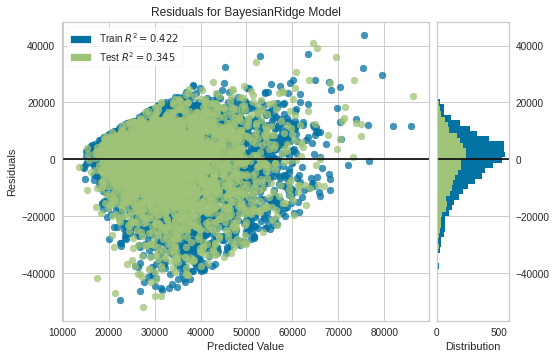

In [96]:
pcr.plot_model(tuned_ridge)

In [92]:
#pcr.plot_model(tuned_ridge, plot='error')

Построим график Feature Importance.

К числу самых важных признаков модель отнесла:

*   Проживание в Санкт-Перербурге и Москве
*   Работа в отраслях, связанных с нефтью и газом
*   Работа в охранном предприятии (почему-то)
*   Руководящая должность (Employment_4)
*   Большая сумма кредита (CreditSum_9.0)




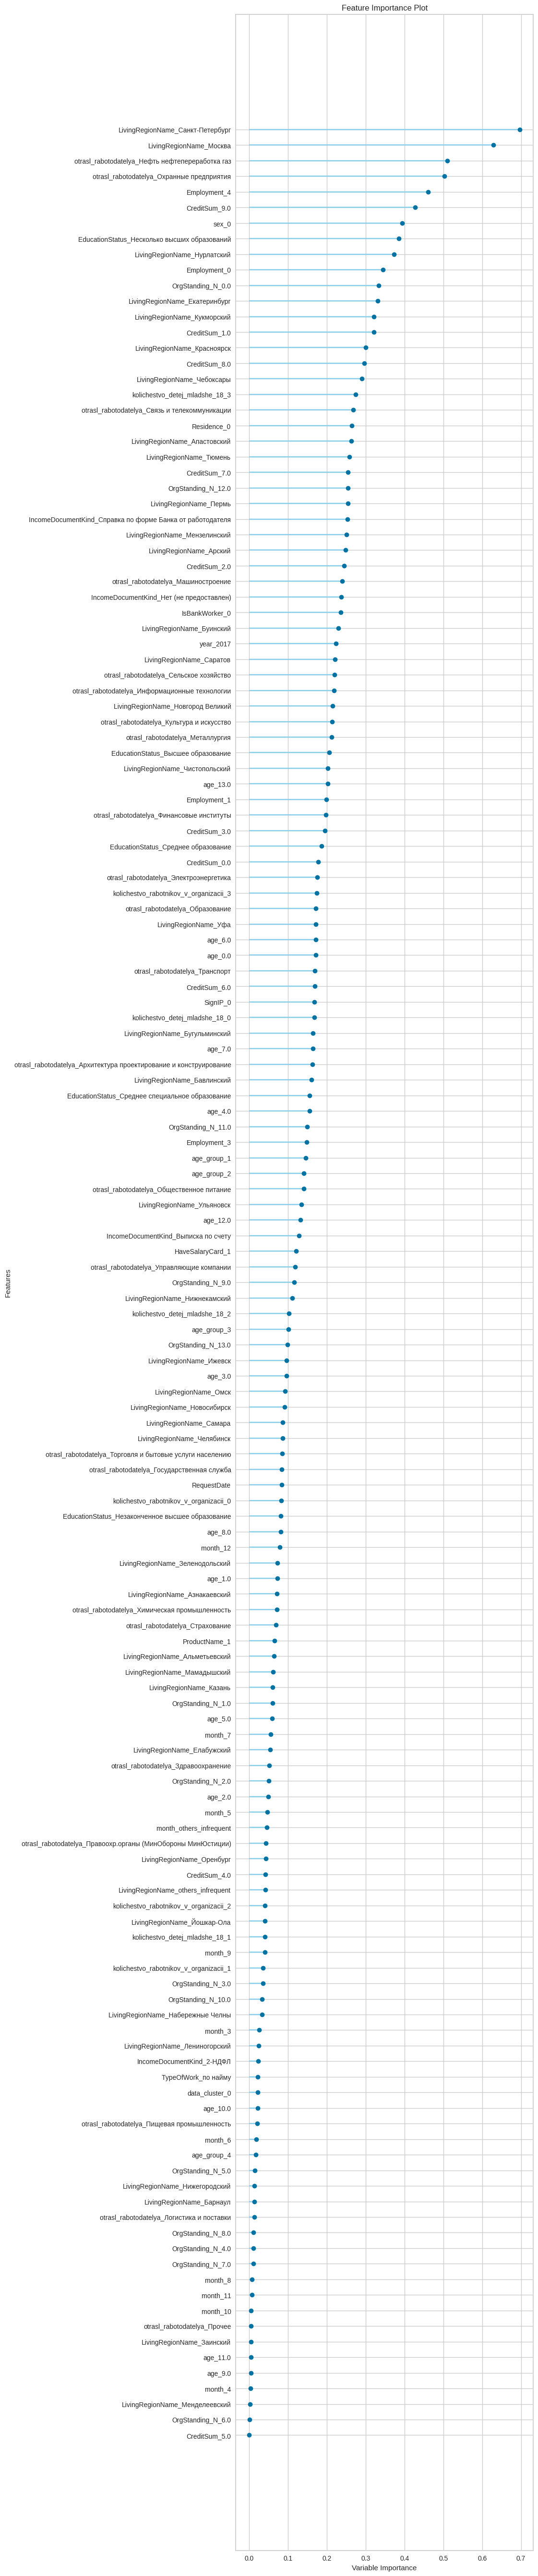

In [104]:
pcr.plot_model(tuned_ridge, plot='feature_all')

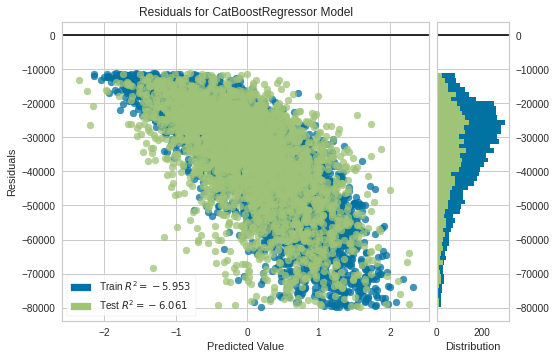

In [87]:
pcr.plot_model(tuned_cat)

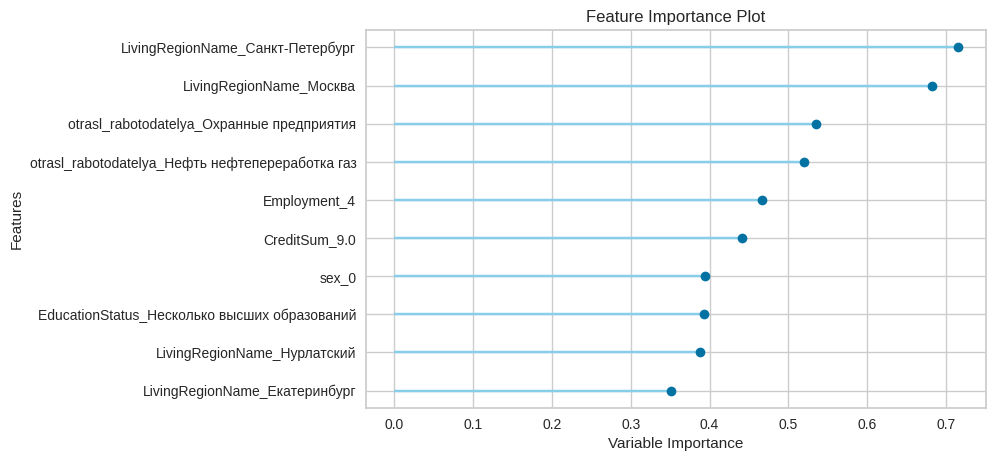

In [88]:
pcr.evaluate_model(tuned_ridge)

In [97]:
pcr.predict_model(tuned_ridge)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,8899.1983,1.390699e+08,11792.7883,0.3453,0.3221,0.2633


,RequestDate,ProductName_1,TypeOfWork_по найму,Employment_0,Employment_1,Employment_3,Employment_4,SignIP_0,sex_0,EducationStatus_Высшее образование,EducationStatus_Незаконченное высшее образование,EducationStatus_Несколько высших образований,EducationStatus_Среднее образование,EducationStatus_Среднее специальное образование,otrasl_rabotodatelya_Архитектура проектирование и конструирование,otrasl_rabotodatelya_Государственная служба,otrasl_rabotodatelya_Здравоохранение,otrasl_rabotodatelya_Информационные технологии,otrasl_rabotodatelya_Культура и искусство,otrasl_rabotodatelya_Логистика и поставки,otrasl_rabotodatelya_Машиностроение,otrasl_rabotodatelya_Металлургия,otrasl_rabotodatelya_Нефть нефтепереработка газ,otrasl_rabotodatelya_Образование,otrasl_rabotodatelya_Общественное питание,otrasl_rabotodatelya_Охранные предприятия,otrasl_rabotodatelya_Пищевая промышленность,otrasl_rabotodatelya_Правоохр.органы (МинОбороны МинЮстиции),otrasl_rabotodatelya_Прочее,otrasl_rabotodatelya_Связь и телекоммуникации,otrasl_rabotodatelya_Сельское хозяйство,otrasl_rabotodatelya_Страхование,otrasl_rabotodatelya_Торговля и бытовые услуги населению,otrasl_rabotodatelya_Транспорт,otrasl_rabotodatelya_Управляющие компании,otrasl_rabotodatelya_Финансовые институты,otrasl_rabotodatelya_Химическая промышленность,otrasl_rabotodatelya_Электроэнергетика,kolichestvo_rabotnikov_v_organizacii_0,kolichestvo_rabotnikov_v_organizacii_1,...,age_1.0,age_10.0,age_11.0,age_12.0,age_13.0,age_2.0,age_3.0,age_4.0,age_5.0,age_6.0,age_7.0,age_8.0,age_9.0,OrgStanding_N_0.0,OrgStanding_N_1.0,OrgStanding_N_10.0,OrgStanding_N_11.0,OrgStanding_N_12.0,OrgStanding_N_13.0,OrgStanding_N_2.0,OrgStanding_N_3.0,OrgStanding_N_4.0,OrgStanding_N_5.0,OrgStanding_N_6.0,OrgStanding_N_7.0,OrgStanding_N_8.0,OrgStanding_N_9.0,CreditSum_0.0,CreditSum_1.0,CreditSum_2.0,CreditSum_3.0,CreditSum_4.0,CreditSum_5.0,CreditSum_6.0,CreditSum_7.0,CreditSum_8.0,CreditSum_9.0,data_cluster_0,ConfirmedMonthlyIncome (Target),Label
0,-1.279295,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,40143.769531,36438.506462
1,-0.145438,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,22943.439453,32065.704700
2,0.540788,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,37365.011719,32978.140933
3,1.459930,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,51672.121094,43314.384335
4,-1.712210,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,38658.949219,37101.028875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [93]:
pcr.predict_model(tuned_cat)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,8786.2403,1.370635e+08,11707.4107,0.3548,0.3216,0.2599


,RequestDate,ProductName_1,TypeOfWork_по найму,Employment_0,Employment_1,Employment_3,Employment_4,SignIP_0,sex_0,EducationStatus_Высшее образование,EducationStatus_Незаконченное высшее образование,EducationStatus_Несколько высших образований,EducationStatus_Среднее образование,EducationStatus_Среднее специальное образование,otrasl_rabotodatelya_Архитектура проектирование и конструирование,otrasl_rabotodatelya_Государственная служба,otrasl_rabotodatelya_Здравоохранение,otrasl_rabotodatelya_Информационные технологии,otrasl_rabotodatelya_Культура и искусство,otrasl_rabotodatelya_Логистика и поставки,otrasl_rabotodatelya_Машиностроение,otrasl_rabotodatelya_Металлургия,otrasl_rabotodatelya_Нефть нефтепереработка газ,otrasl_rabotodatelya_Образование,otrasl_rabotodatelya_Общественное питание,otrasl_rabotodatelya_Охранные предприятия,otrasl_rabotodatelya_Пищевая промышленность,otrasl_rabotodatelya_Правоохр.органы (МинОбороны МинЮстиции),otrasl_rabotodatelya_Прочее,otrasl_rabotodatelya_Связь и телекоммуникации,otrasl_rabotodatelya_Сельское хозяйство,otrasl_rabotodatelya_Страхование,otrasl_rabotodatelya_Торговля и бытовые услуги населению,otrasl_rabotodatelya_Транспорт,otrasl_rabotodatelya_Управляющие компании,otrasl_rabotodatelya_Финансовые институты,otrasl_rabotodatelya_Химическая промышленность,otrasl_rabotodatelya_Электроэнергетика,kolichestvo_rabotnikov_v_organizacii_0,kolichestvo_rabotnikov_v_organizacii_1,...,age_1.0,age_10.0,age_11.0,age_12.0,age_13.0,age_2.0,age_3.0,age_4.0,age_5.0,age_6.0,age_7.0,age_8.0,age_9.0,OrgStanding_N_0.0,OrgStanding_N_1.0,OrgStanding_N_10.0,OrgStanding_N_11.0,OrgStanding_N_12.0,OrgStanding_N_13.0,OrgStanding_N_2.0,OrgStanding_N_3.0,OrgStanding_N_4.0,OrgStanding_N_5.0,OrgStanding_N_6.0,OrgStanding_N_7.0,OrgStanding_N_8.0,OrgStanding_N_9.0,CreditSum_0.0,CreditSum_1.0,CreditSum_2.0,CreditSum_3.0,CreditSum_4.0,CreditSum_5.0,CreditSum_6.0,CreditSum_7.0,CreditSum_8.0,CreditSum_9.0,data_cluster_0,ConfirmedMonthlyIncome (Target),Label
0,-1.279295,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,40143.769531,35789.033175
1,-0.145438,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,22943.439453,32450.133303
2,0.540788,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,37365.011719,31971.065023
3,1.459930,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,51672.121094,39588.576027
4,-1.712210,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,38658.949219,37769.137220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,